# Animation de Percussion 1D

In [363]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from IPython.display import Image
from ipywidgets import interact

import imageio, io
import os
import PIL.Image as PILImage

# import glob
# from pathlib import Path
# from natsort import natsorted

%reset

Ce notebook présente une animation de la percussion entre deux floes.

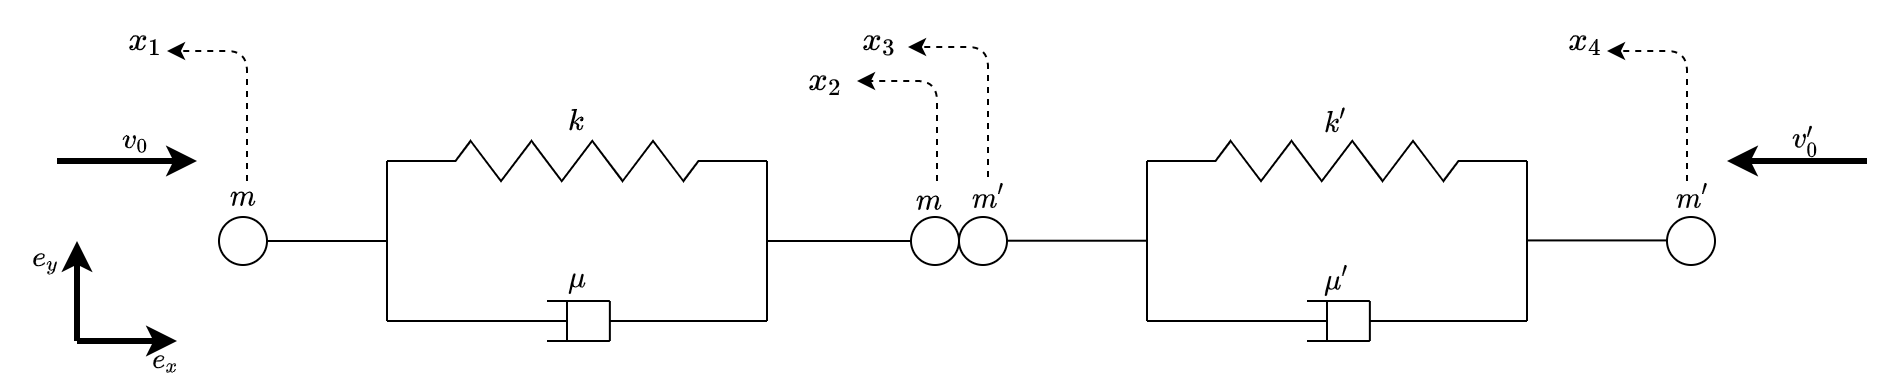

In [364]:
Image("../../reports/internship/Figures/Percussion1D-Systeme-3.png")

Les étapes à suivre:
1. Definir les constantes. Le temps se divise en deux:
    - Le temps avant le choc 
    - Le temps après le choc
2. Calculer les positions (avant et après le choc). On commence simplement avec un mouvement uniforme avant le choc
3. Une fonction pour dessiner un ressort
4. Une fonction pour dessiner un dispositif visqueux (inutile pour l'instant)
5. Une fonction pour dessiner un floe 1D au temps step
6. Faire les graphiques et les placer dans la liste au fur et à mesure

Pour la phase 2:
1. Calculer la deplacements de x_1, x_2, x_3, x_4 dans un modele 1D-0 (les V_0, V'_0etc seront les vitesses initiales)
2. Obtenir la vitesse de translation du floe entier de la thèse de rabatel. Les positions z_1, z_2, z_3, et z_4 pouront donc etre calculées
3. Addition x_1 à z_1, etc.

In [365]:
## Problem constants
m = 1.0
m_ = 1.0

k = 16.0
k_ = 5.0

mu = 6.0
mu_ = 2.0

v0=2.2
v_0=2.8

eps=0.8

In [366]:
## Geometric constants
L = 20.0
H = 1.5

L0 = L/10.0     # Spring 1 length at rest
L_0 = L/8.0    # Spring 2 length at rest

R = H/6.0      # Radius for the balls at the end of the springs

z0 = 0
z_0 = L-L_0

In [367]:
""" Définitions des temps de simulation  """
N=2000
tminus=0.0          # debut du contact
tplus=1.0           # fin du contact

## Avant le contact
tmax1 = ((z_0-R) - (z0 + L0+R)) / (v0 + v_0)       ## Calculer tmax a la main pour correspondre au moment du contact
t = np.linspace(0, tmax1, N+1)
dt = tmax1 / N

## Apres le contact
tmax2 = 5

In [368]:
## Positions of the first ice-floe before collision
def uniform_mouvement_1(y,t):
    return v0
z = odeint(uniform_mouvement_1, z0, t)[:,0]

## Positions of the second ice-floe before collision
def uniform_mouvement_2(y,t):
    return -v_0
z_ = odeint(uniform_mouvement_2, z_0, t)[:,0]

In [369]:
# # print(z)
# # print(z_)

## Detection of the collision position
# contactPos = v0*(L-L_0)/(v0+v_0)
# print(contactPos)
# print(-v_0*(L-L_0)/(v0+v_0) + L-L_0)

# newZ = z[z<contactPos]
# print(newZ)

# newZ_ = z_[z_>(contactPos+L0)]
# print(newZ_)
# print(newZ_.size)

In [370]:
## Calculating the speeds after contact
I = 0.0    ## Needs to be perfected !
V0 = (I + (m + eps*m_)*v0 + (1-eps)*m_*v_0) / (m+m_)
V_0 = (I + (1-eps)*m*v0 + (m_ + eps*m)*v_0) / (m+m_)

print("First floe speeds:", v0, V0)
print("Second floe speeds:", V_0, v_0)


## Positions of the first ice-floe after collision
def new_uniform_mouvement_1(y, t):
    return -np.abs(v0 - V0)
Z = odeint(new_uniform_mouvement_1, z[-1], t)[:,0]

## Positions of the second ice-floe after collision
def new_uniform_mouvement_2(y, t):
    return np.abs(V_0 - v_0)
Z_ = odeint(new_uniform_mouvement_2, z_[-1], t)[:,0]


## Positions (displacements) of the first floe after collision
Delta = mu*mu - 2*k*m
print("Delta:", Delta)
if Delta > 0:
    lambda1 = (-mu - np.sqrt(Delta))/m
    lambda2 = (-mu + np.sqrt(Delta))/m
    x1 = Z + 0.5*t*(v0 - V0) + (np.exp(t*lambda1) - np.exp(t*lambda2))*(v0 + V0)/(2*(lambda2 - lambda1))
    x2 = Z_ + 0.5*t*(V_0 - v_0) - (np.exp(t*lambda1) - np.exp(t*lambda2))*(V_0 + v_0)/(2*(lambda2 - lambda1))
else:
    alpha = -mu/m
    beta = - np.sqrt(-Delta)/m
    x1 = Z + 0.5*t*(v0 - V0) + np.exp(t*alpha)*np.sin(beta*t)*(v0 + V0)/(2*beta)
    x2 = Z_ + 0.5*t*(V_0 - v_0) - np.exp(t*alpha)*np.sin(beta*t)*(V_0 + v_0)/(2*beta)

t = np.concatenate([t, t])
# print(t.shape)
z = np.concatenate([z, x1])
z_ = np.concatenate([z_, x2])

First floe speeds: 2.2 2.2600000000000002
Second floe speeds: 2.74 2.8
Delta: 4.0


In [371]:
## Une fonction pour dessiner un ressort
def plot_spring(x, y, theta, L, H, L0, ax):
    """ Plot the spring from (x,y) with length L and height H as the projection of a helix."""
    # Spring turn radius, number of turns
    rs, ns = 0.05, int(5*L0)
    # Number of data points for the helix
    Ns = 1000
    # We don't draw coils all the way to the end of the pendulum:
    # pad a bit from the anchor and from the bob by these number of points
    ipad1, ipad2 = 150, 150
    w = np.linspace(0, L, Ns)
    # Set up the helix along the x-axis ...
    xp = np.zeros(Ns)
    xp[ipad1:-ipad2] = rs * np.sin(2*np.pi * ns * w[ipad1:-ipad2] / L)
    # ... then rotate it to align with  the pendulum and plot.
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    xs, ys = - R @ np.vstack((xp, w))
    ax.plot(x+xs, y+(H*ys)/np.max(ys), c='k', lw=2)

## Une fonction pour dessiner un noeud de ressort
def plot_circle(x, y, R, ax):
    # Circle at position (x,y) with radius R
    c = Circle((x, y), R, fc='white', ec='k', lw=2, zorder=10)
    ax.add_patch(c)

## Une fonction pour dessiner un floe de glace (systeme masse-ressort)
def plot_ice_floe(x1,y1, x2,y2, R, L0, ax):
    """ Plot an ice floe whose nodes are at (x1,y1) and (x2,y2) with same radius R """
    plot_circle(x1,y1,R,ax)
    plot_circle(x2,y2,R,ax)
    if x1 > x2:
        tmp = x2
        x2 = x1
        x1 = tmp
    elif x1 == x2:
        print("Carefull: zero sized spring!")

    plot_spring(x1+R/2, 0, np.pi/2.0, x2-x1-R, R/1.2, L0, ax)

In [372]:
# """ Clear the given directory of all PNG files """
# def clear_dir(path):
#     files = glob.glob(path+'/*.png', recursive=True)
#     for f in files:
#         try:
#             os.remove(f)
#         except OSError as e:
#             print("Error: %s : %s" % (f, e.strerror))

In [373]:
def fig2img(fig):
    """ Convert a Matplotlib figure to a PIL Image and return it """
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight')
    buf.seek(0)
    img = PILImage.open(buf)
    # img = plt.imread(buf)
    return img


In [374]:
def make_plot(i, path, ax):
    """
    Plot and save an image of the system configuration for time point i.
    """
    plot_ice_floe(z[i],0, z[i]+L0,0, R, L0, ax)
    plot_ice_floe(z_[i],0, z_[i]+L_0,0, R, L_0, ax)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(0, L)
    ax.set_ylim(-2*R, 2*R)
    ax.set_aspect('equal', adjustable='box')
    # plt.axis('off')
    # plt.savefig(path+'/_img{:04d}.png'.format(i//di), dpi=72)
    img_list.append(fig2img(fig))
    # Clear the Axes ready for the next image.
    plt.cla()

0 / 60
1 / 60
2 / 60
3 / 60
4 / 60
5 / 60
6 / 60
7 / 60
8 / 60
9 / 60
10 / 60
11 / 60
12 / 60
13 / 60
14 / 60
15 / 60
16 / 60
17 / 60
18 / 60
19 / 60
20 / 60
21 / 60
22 / 60
23 / 60
24 / 60
25 / 60
26 / 60
27 / 60
28 / 60
29 / 60
30 / 60
31 / 60
32 / 60
33 / 60
34 / 60
35 / 60
36 / 60
37 / 60
38 / 60
39 / 60
40 / 60
41 / 60
42 / 60
43 / 60
44 / 60
45 / 60
46 / 60
47 / 60
48 / 60
49 / 60
50 / 60
51 / 60
52 / 60
53 / 60
54 / 60
55 / 60
56 / 60
57 / 60
58 / 60
59 / 60
60 / 60


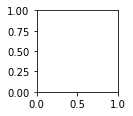

In [375]:
"""
# Make an image every di time points, corresponding to a frame rate of fps
"""
path = "frames"
fps = 10
di = int(1/fps/dt)
# This figure size (inches) and dpi give an image of .
fig = plt.figure(figsize=(L, H), dpi=72)
ax = fig.add_subplot(111)

# clear_dir(path)
img_list = []

for i in range(0, t.size, di):
    print(i // di, '/', t.size // di)
    make_plot(i, path, ax)


In [376]:
# imageio.mimwrite('Animation1D.gif', image_list, loop=3, duration=total_duration/nb_frames)
imageio.mimwrite('Animation1D.gif', img_list)

In [377]:
# Image("Animation1D.gif")
os.system('eog Animation1D.gif')     ## Only on Linux GNOME


1

In [378]:
""" A partir d'ici il faut faire la sauvegarde sur le disque """








" A partir d'ici il faut faire la sauvegarde sur le disque "

In [379]:
# """ Read the image from memory """
# image_path = Path('./frames')
# images_paths = list(image_path.glob('*.png'))
#
# image_names = []
# for file_name in images_paths:
#     image_names.append(str(file_name))
# image_names = natsorted(image_names)
#
# image_list = []
# for file_name in image_names:
#     image_list.append(imageio.imread(file_name))
#
# print(image_names[:5])

In [380]:
# nb_frames = len(image_list)
# total_duration = 10.0
# fps = nb_frames * 100 / total_duration
#
# imageio.mimwrite('Animation1D.gif', image_list, loop=3, duration=total_duration/nb_frames)
# imageio.mimwrite('Animation1D.gif', image_list)

In [381]:
# Image("Animation1D.gif")
# os.system('eog Animation1D.gif')     ## Only on Linux GNOME